# CIFAR3 perfect discrimination transformation:

In [1]:
%load_ext autoreload

In [2]:
%autoreload 1

In [3]:
import os
import sys
import time
import random
sys.path.append('..')

import numpy as np
import matplotlib.pyplot as plt
from scipy.special import softmax
from sklearn.isotonic import IsotonicRegression
import torch

%aimport utils
%aimport utils.ops
%aimport utils.metrics
%aimport utils.visualization
%aimport calibrators
from utils.data import get_cifar3, load_logits
from utils.ops import onehot_encode, optim_temperature, detection_log_likelihood_ratios
from utils.metrics import neg_log_likelihood, expected_calibration_error
from utils.visualization import plot_pdf_simplex, plot_prob_simplex, reliability_plot, reliability_diagram, ECE_plot, plot_cal_regions_ternary
from flows.normalizing_flows_torch import PlanarFlow, RadialFlow
from flows.nice_torch import NiceFlow
from flows.realNVP_torch import RealNvpFlow
from calibrators import TorchFlowCalibrator

C:\Users\sergi\Anaconda3\envs\calib\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\sergi\Anaconda3\envs\calib\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\sergi\Anaconda3\envs\calib\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\sergi\Anaconda3\envs\calib\lib\site-packages\tensorflow\python\f

In [4]:
# Select GPU to use
os.environ["CUDA_VISIBLE_DEVICES"]="1"; 

In [5]:
%matplotlib inline
np.random.seed(1)

## Load data

In [6]:
cifar_dir = '../cifar-10'
models_dir = '../pretrained-models'

model = 'cnn_cifar3'

cifar3, ix2label = get_cifar3(cifar_dir, test=True)
target = onehot_encode(cifar3['test_labels'])

_, logits = load_logits(os.path.join(models_dir, model))
probs = softmax(logits, axis=1)

## Train super-expressive flow:

In [7]:
## RealNVP flow
t0 = time.time()
nvp_cal = TorchFlowCalibrator(RealNvpFlow, logits, target, layers=10, hidden_size=[5, 5], epochs=10000)
print('Fitted RealNVP in {:.3f}s'.format(time.time()-t0))
nvp_probs = nvp_cal.predict(logits)

nll_nvp = neg_log_likelihood(nvp_probs, target)
ECE_nvp = expected_calibration_error(nvp_probs, target)

Fitted RealNVP in 19948.634s


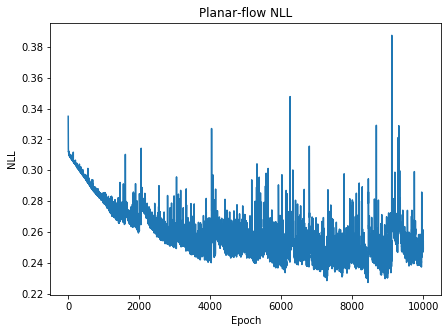

In [8]:
# Plot training NLL
fig, ax = plt.subplots(figsize=(7, 5))

ax.plot(nvp_cal.history['loss'])
ax.set_title('Planar-flow NLL')
ax.set_ylabel('NLL')
ax.set_xlabel('Epoch')

plt.show()

In [9]:
nll_nvp

0.2490470044899152